# Composition based on Centones in Arab-Andalusian Music

Notebook that looks for characteristic centones of the 26 tubu's of the Arab Andalusian Music in a score. Then, show the results to link the number of found centones with the correspondance main tab' of the score.

In [1]:
%load_ext autoreload

%autoreload 2

In [1]:
from music21 import *
from compmusic import dunya
import os
import re
import copy
import csv
import json
import pandas as pd
from pathlib import Path
from operator import itemgetter
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
dunya.set_token('52fc6ac49c0b7fc9644404aaf4f9bc1a7088d69d')

apipath = 'api/andalusian/recording/'

In [51]:
import sys
sys.path.append('../src/')

import extraction
import model
import persistence
import reporting

## Step 1: Load CSV
Download the metadata and the score of each recording, to have the .musicxml file and the annotated tab'.

In [2]:
def load_and_parse_centones_mapping(mapping_path):
    """
    Load csv of centone mapping to dict
    """
    centones = pd.read_csv(mapping_path, header=None)
    return {'Nawba_{}'.format(x[0]):[y.replace(' ','') for y in list(x[1:]) if str(y) != 'nan'] \
            for i, x in centones.iterrows()}

In [4]:
# Nawba Mappings
nawba_centones = load_and_parse_centones_mapping('../data/Centones_Nawba.csv')

with open('../data/nawba_tabs.json', 'r') as fp:
    nawba_tabs = json.load(fp)
    
tabs_nawba = {}
for k,v in nawba_tabs.items():
    for t in v:
        tabs_nawba[t] = k
        
# Recording Description
andalusian_description =  pd.read_json('../data/andalusian_description.json')

# Step 2: Download scores

In [5]:
scores = []
for i, row in andalusian_description.iterrows():
    try:
        tn = row['sections'][0]['tab']['transliterated_name']
    except:
        tn = ''
    scores.append([row['mbid'], tn])


Download the required scores from Dunya through the cell below:

In [161]:
if not os.isdir('Scores'):
    os.mkdir('Scores')

bad_mbid = []
for s in scores: # Download scores from dunya through its mbid
    mbid = s[0]
    try:
        score_xml = dunya.docserver.file_for_document(mbid, 'symbtrxml')
        name = mbid + '.xml'
        path = os.path.join('Scores', name)
        open(path, "wb").write(score_xml)
    except: 
        bad_mbid.append(mbid)

scores = [x for x in scores if x[0] not in bad_mbid]

In [34]:
# Replace tab with nawba
scores_nawba = [[x[0], tabs_nawba[x[1]]] for x in scores if x[1] in tabs_nawba]

# Lookup
nawba_lookup = {x[0]:x[1] for x in scores_nawba}

In [52]:
notes_dict = {}
chord_mbid = []

for i,(mbid, nawba) in enumerate(scores_nawba):
    this_score_path = os.path.join('../data/scores', mbid + '.xml')
    # Fails for scores with chords
    try:
        note_stream = persistence.pattern_stream_from_score(this_score_path, 4)
        notes_dict[mbid] = note_stream
    except Exception as e:
        print('{} contains chords and wont be counted'.format(mbid))
        chord_mbid.append(mbid)

final_scores = [x for x in scores_nawba if x[0] not in chord_mbid]

2d8e2820-e4cf-4dc8-b4f1-45f8fb65de9e contains chords and wont be counted


In [71]:
notes_name=[n for n in notes_dict['b6091182-8877-4918-b637-77987c4a1034']]
notes_name = ''.join(notes_name)
notes_name
occurrences(notes_name,'GGF#')

56

Load a csv file that contains all the characteristic centones for each tab' and the final centones for each tab and store it in a dictionary (data and data_final)

## Step 2: Searching general centones
For each score in the dataset, look for the characteristic centones of each tab' and store the results in a final dataframe. In this dataframe will be stored a coefficient and the name of the 10 most likely tubu's related with this coefficient. This coefficient is the normalization of the occurrances of the centones for each tab' in the recording. (Running next cell might can take around 10 minutes)

In [64]:
def count_letters(x): # This function will be used to count the length of each centon.
        counter = 0
        for let in x:
            if let!='-' and let!='#':
                counter+=1
        return counter
def occurrences(string, sub):
    count = start = 0
    while True:
        start = string.find(sub, start) + 1
        if start > 0:
            count+=1
        else:
            return count
        
def count_centones(mbid,notes_dict,nawba_centones):
    notes_name=[n for n in notes_dict[mbid]]
    notes_name = ''.join(notes_name)
    # Count centones:
    nawba_and_ncentones = []
    for d in nawba_centones: # For each tab' we count the number of centones
        ncentones = []
        for centon in nawba_centones[d]: # count the number of apperances of every centon in the set of centones of the tab'
            numbercentones = occurrences(notes_name, centon)
            ncentones.append(numbercentones) # Acumulate the number of every kind of centones in a list
        nawba_and_ncentones.append([d, sum(ncentones)]) # Store in a list of tuples [(name of tab', appearances of characteristics centones)]

    nawba_and_ncentones = [[x[0],x[1]/len(nawba_centones[x[0]])] for x in nawba_and_ncentones]
    predicted = [x[0] for x in sorted(nawba_and_ncentones, key=lambda y: -y[1])]
    return predicted
    

df = []
number_centones_nawba={}
mbids_final=[x[0] for x in final_scores]
for mbid in tqdm(mbids_final):
    path = '../data/scores'
    fileName = mbid + '.xml'
    fn = os.path.join(path, fileName)
    fn = Path(fn)
    nawba = nawba_lookup[mbid]
    predicted_nawba = count_centones(notes_dict,mbid)
    df.append({'Mbid':mbid, 'Annotated_tab': nawba,'1 tab': predicted_nawba})




  0%|          | 0/149 [00:00<?, ?it/s]


 17%|█▋        | 26/149 [00:00<00:00, 255.79it/s]


 41%|████      | 61/149 [00:00<00:00, 277.41it/s]


 59%|█████▉    | 88/149 [00:00<00:00, 273.06it/s]


 74%|███████▍  | 110/149 [00:00<00:00, 253.40it/s]


 89%|████████▉ | 133/149 [00:00<00:00, 242.54it/s]


100%|██████████| 149/149 [00:00<00:00, 261.45it/s]

In [75]:
nawba_centones

{'Nawba_1': ['B-AG',
  'EFG',
  'FAG',
  'AGF',
  'CDEF',
  'FEDC',
  'BCE',
  'FED',
  'GFED',
  'FDECD',
  'FAG',
  'EFG',
  'CBAG',
  'GAF',
  'AGF',
  'DEF',
  'FGA',
  'BCA',
  'BGA',
  'FEDC',
  'FED',
  'FDECD',
  'EFG',
  'CBAG',
  'FAG',
  'CDEF',
  'GFE',
  'FEDC',
  'FGA',
  'CBA',
  'DCB',
  'FDECD',
  'GFED',
  'FGDBCD',
  'FED',
  'FEDC',
  'FGA',
  'CDEF',
  'AGF'],
 'Nawba_2': ['CBAG',
  'EFG',
  'GFE',
  'BDC',
  'FEDC',
  'DCB',
  'FED',
  'BCD',
  'CFED',
  'FEFGDBCD',
  'CBAG',
  'GFE',
  'BCD',
  'CFED',
  'BCD'],
 'Nawba_3': ['B-AG', 'EFG', 'BDC', 'BC', 'EFGEFEDC', 'GFE'],
 'Nawba_4': ['EFG',
  'B-AG',
  'BCD',
  'GE',
  'CDGFEDCDEC',
  'CDEC',
  'CDAGFEDC',
  'CDCEDC',
  'CAGC'],
 'Nawba_5': ['GFE',
  'EFG',
  'FAG',
  'GABCAG',
  'ABC',
  'FEDC',
  'EDC',
  'EFG',
  'CDE',
  'GFE'],
 'Nawba_6': ['F#GA',
  'GE',
  'CDE',
  'EDC',
  'EF#G',
  'BAG',
  'DCAG',
  'CAG',
  'DECD',
  'CBAG',
  'CDE',
  'EDC',
  'AGF#E-DC',
  'GF#E-D',
  'FGA',
  'CBCA',
  'EFG',
  'AG

The computed data can be visualized in the next dataframe

In [74]:
df_centones= pd.DataFrame(df)
df_centones= df_centones[['Mbid','Annotated_tab','1 tab']]
df_centones
df_centones[df_centones['Annotated_tab'] == 'Nawba_2']
#df_centones.to_pickle('nawba_results')

,Mbid,Annotated_tab,1 tab
8,36822512-b1c8-42aa-9e55-fe9d10560371,Nawba_2,"[Nawba_5, 107.9]"
23,d2830817-7b06-4f98-bba5-daf8ae9f85be,Nawba_2,"[Nawba_5, 49.5]"
24,fb387964-4764-4900-91b5-f2ea7e10b786,Nawba_2,"[Nawba_5, 119.8]"
32,04b42450-8838-4a20-9e79-d42f03f8cc51,Nawba_2,"[Nawba_7, 69.10526315789474]"
44,ec5d2ba0-7c04-4d87-83b9-f82d363ca319,Nawba_2,"[Nawba_5, 168.2]"
56,59fcb1d1-61f4-4cdc-9f7f-56757bf2400e,Nawba_2,"[Nawba_5, 140.8]"
65,a0f4157f-faa1-4304-ac75-b612587fb221,Nawba_2,"[Nawba_7, 46.0]"
85,3bb348f5-417d-4646-9041-42b935c54c28,Nawba_2,"[Nawba_5, 112.7]"
98,aecf65c2-ef6a-4e7a-a123-24fbe757684e,Nawba_2,"[Nawba_5, 142.4]"
101,6aa540dc-e857-4115-9b90-a0480eb5316f,Nawba_2,"[Nawba_5, 169.1]"


The cell below review the computed datas in percentages

The tab with the most number of characteristics centones and the annotations matched in:  20.80536912751678 %


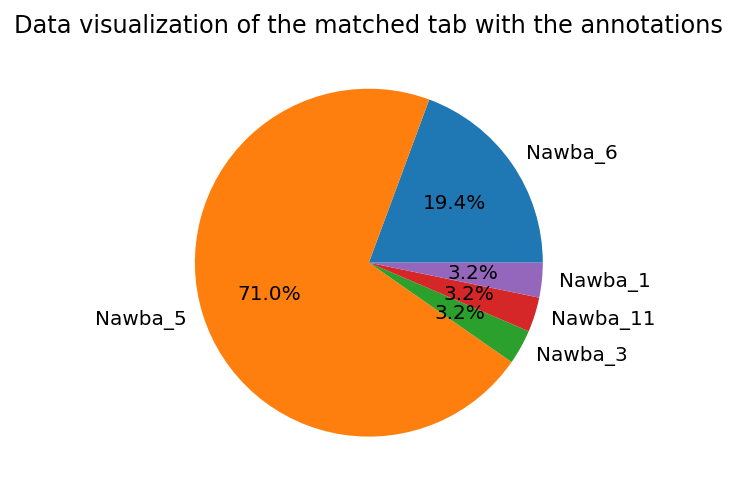

In [66]:
cont=0
tab_work=[]
for index, row in df_centones.iterrows():
    if row['Annotated_tab']==row['1 tab'][0]:
        tab_work.append(row['Annotated_tab'])
        cont += 1
print('The tab with the most number of characteristics centones and the annotations matched in: ',cont*100/(df_centones.shape[0]),'%')
    
values = Counter(tab_work).values()
keys = Counter(tab_work).keys()
plt.pie([v for v in values], labels=[k for k in keys],autopct='%.1f%%')
plt.title('Data visualization of the matched tab with the annotations')
plt.show()

Confusion matrix, without normalization


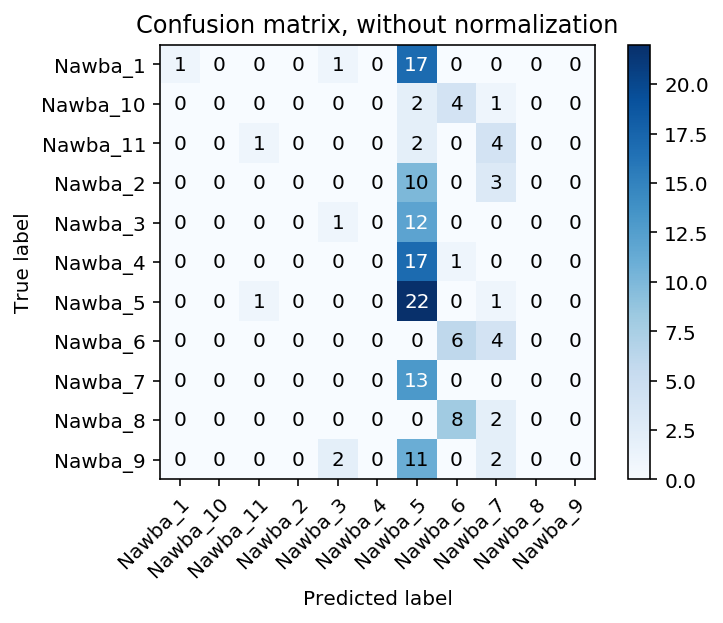

In [73]:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    #fig.tight_layout()
    return ax

annotated = df_centones['Annotated_tab'].tolist()
predicted = df_centones['1 tab'].tolist()
predicted = [x[0] for x in predicted]

np.set_printoptions(precision=2)


plot_confusion_matrix(annotated, predicted,title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
#plot_confusion_matrix(annotated, predicted, classes=classes, normalize=True,
                      #title='Normalized confusion matrix')

plt.show()